In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F

plt.rcParams["figure.dpi"] = 300
sns.set(style="whitegrid")
plt.rcParams.update(
    {
        "axes.linewidth": 1,
    }
)

img_size_list = [96, 112, 128, 160, 192, 224]
cost = [
    408610406400,
    552160198656,
    717794574336,
    1115317075968,
    1601177911296,
    2175377080320,
]

In [2]:
with open("dump.pkl", "rb") as f:
    dump = pickle.load(f)

In [3]:
images = pd.Series(dump["images"])
idx_to_keep = images[~images.duplicated(keep="first")].index.to_list()
images_count = len(idx_to_keep)
target = dump["target"][idx_to_keep]
outputs = dump["outputs"][:, idx_to_keep, :]
attn_scores = [i[idx_to_keep, :, :] for i in dump["attn_scores"]]

In [4]:
target.shape, outputs.shape, len(attn_scores), attn_scores[0].shape

(torch.Size([49971]),
 torch.Size([6, 49971, 1000]),
 6,
 torch.Size([49971, 12, 36]))

In [5]:
def evaluate_choice(which=None, first_pass=-1, pure=5):
    if which is None:
        first_pass = -1
        which = [pure] * images_count
    pred = outputs.argmax(dim=2)
    better_pred = pred[which, range(pred.shape[1])]
    which_value_counts = np.bincount(which, minlength=len(img_size_list))
    if first_pass >= 0:
        which_value_counts[first_pass] = images_count
    return (better_pred == target.unsqueeze(0)).sum().item() / len(target) * 100, sum(
        cost[i] * v for i, v in enumerate(which_value_counts)
    ) / images_count

In [6]:
acc_cost_ori = pd.DataFrame(
    [evaluate_choice(pure=i) for i in range(len(img_size_list))]
)
acc_cost_ori["label"] = "original"

In [7]:
hit1 = outputs.argmax(dim=2) == target.unsqueeze(0)
hit1_minres = pd.DataFrame(hit1.nonzero()).groupby(1).min().to_dict()[0]
hit1_minres = [hit1_minres[i] if i in hit1_minres else 7 for i in range(images_count)]

<Axes: >

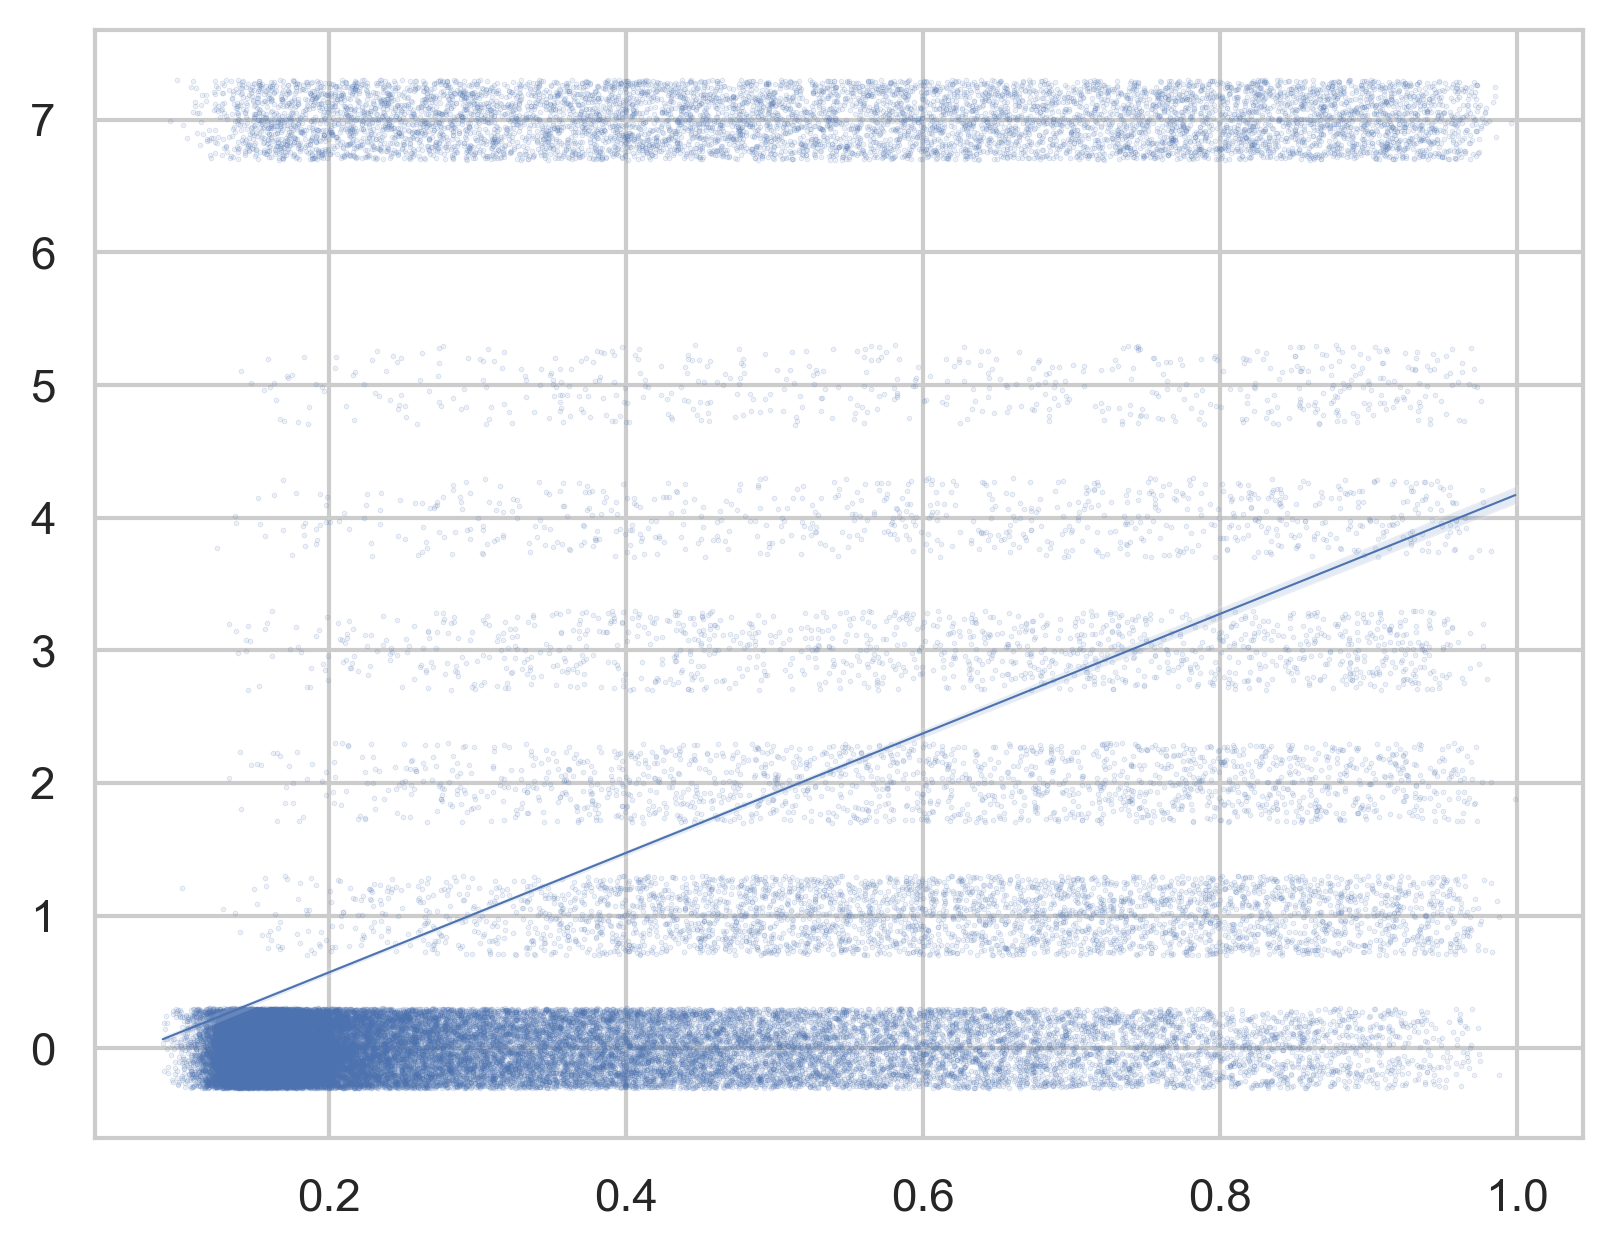

In [8]:
confidence_96 = F.softmax(outputs[0], dim=1).var(dim=1).numpy()
confidence_96 = 0.3 ** (confidence_96 / confidence_96.mean())

sns.regplot(
    x=confidence_96,
    y=hit1_minres,
    y_jitter=0.3,
    scatter_kws={"s": 0.1, "alpha": 0.2},
    line_kws={"lw": 0.5},
)

<Axes: >

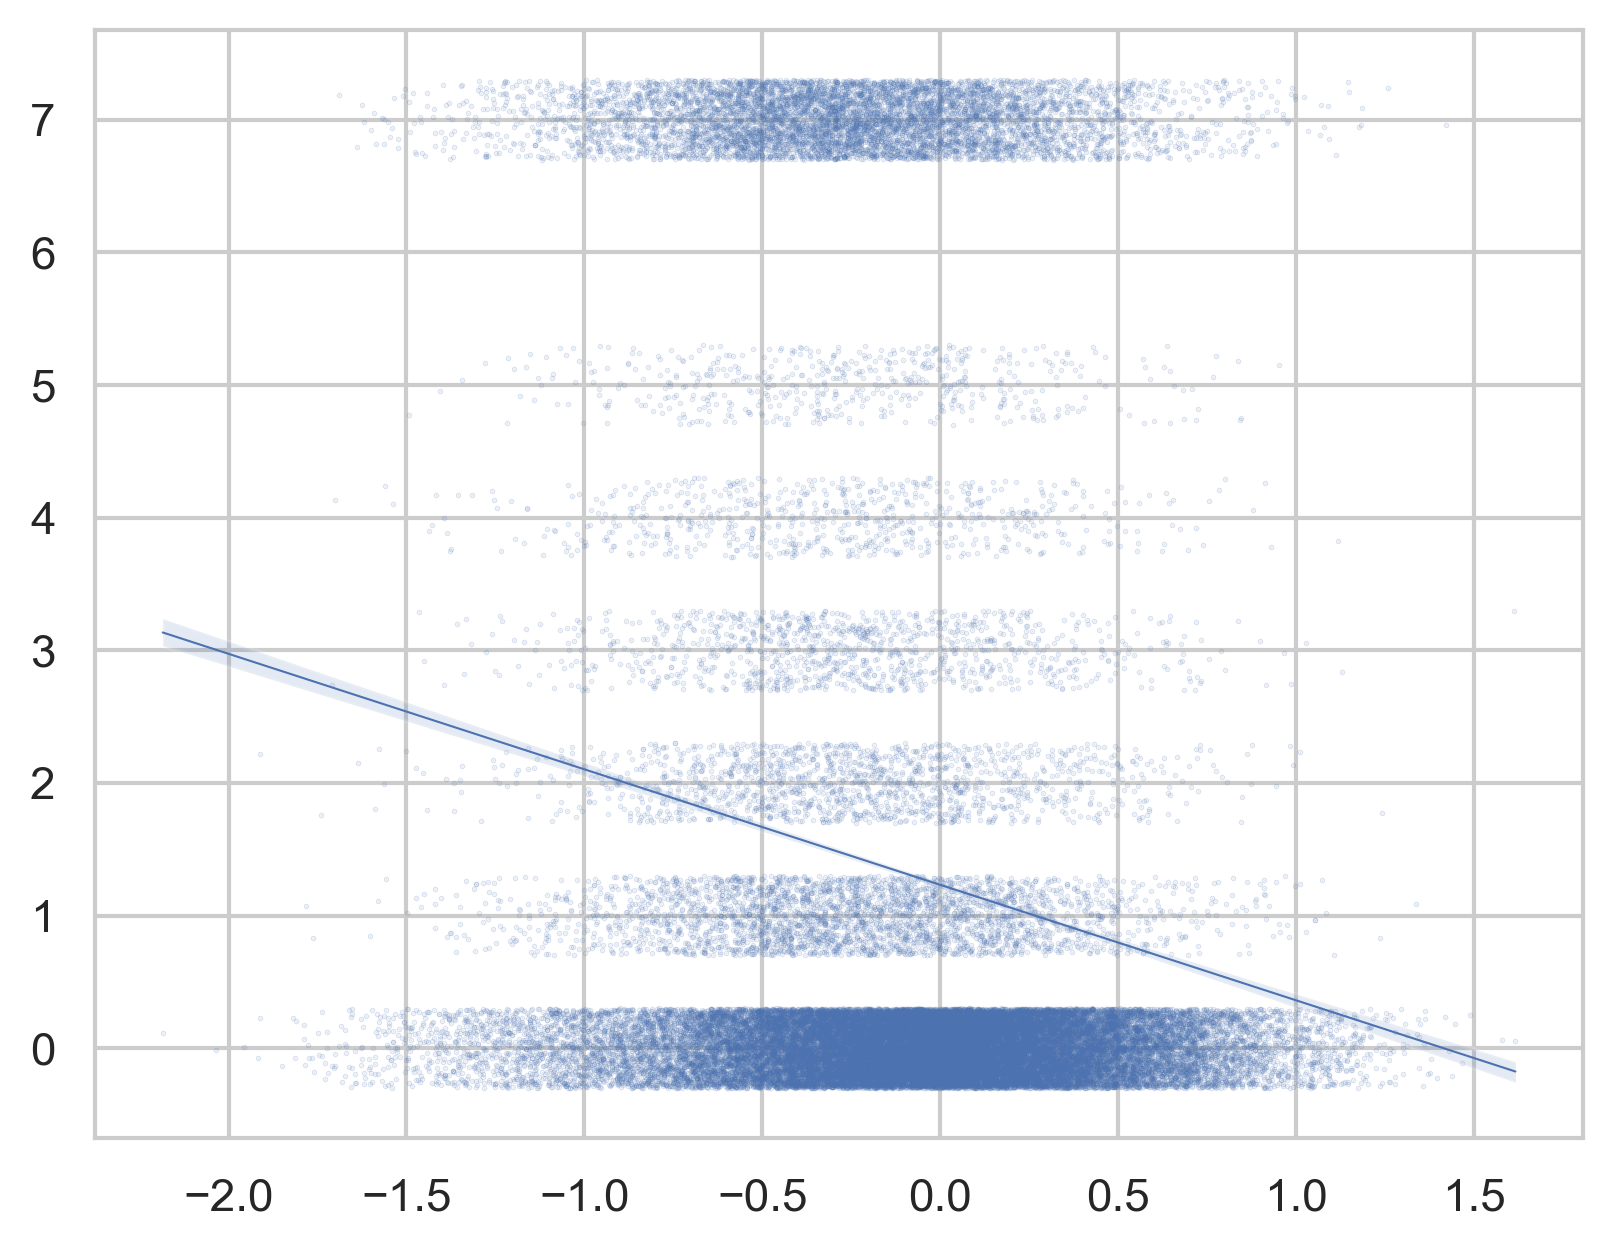

In [9]:
attn_stats_96 = attn_scores[0].numpy().var(axis=2).mean(axis=1)
attn_stats_96 = np.log(attn_stats_96 / attn_stats_96.mean())

sns.regplot(
    x=attn_stats_96,
    y=hit1_minres,
    y_jitter=0.3,
    scatter_kws={"s": 0.1, "alpha": 0.2},
    line_kws={"lw": 0.5},
)

In [10]:
from sklearn import linear_model

In [11]:
acc_cost = []
for i in range(4):
    confidence = F.softmax(outputs[i], dim=1).var(dim=1).numpy()
    confidence = 0.3 ** (confidence / confidence.mean())
    X = np.concatenate([confidence.reshape(-1, 1)], axis=1)

    reg = linear_model.LinearRegression()
    reg.fit(X[:1000, :], hit1_minres[:1000])

    acc_cost_new_list = []
    for j in np.arange(0.2, 5, 0.1):
        which = np.clip(reg.predict(X), 0, 5) * j
        which = np.clip(np.round(which), i, 5).astype(int)
        acc_cost_new_list.append(evaluate_choice(which, first_pass=i))
    acc_cost_new = pd.DataFrame(acc_cost_new_list)
    acc_cost_new["label"] = f"1st pass res. {img_size_list[i]}"
    acc_cost.append(acc_cost_new)

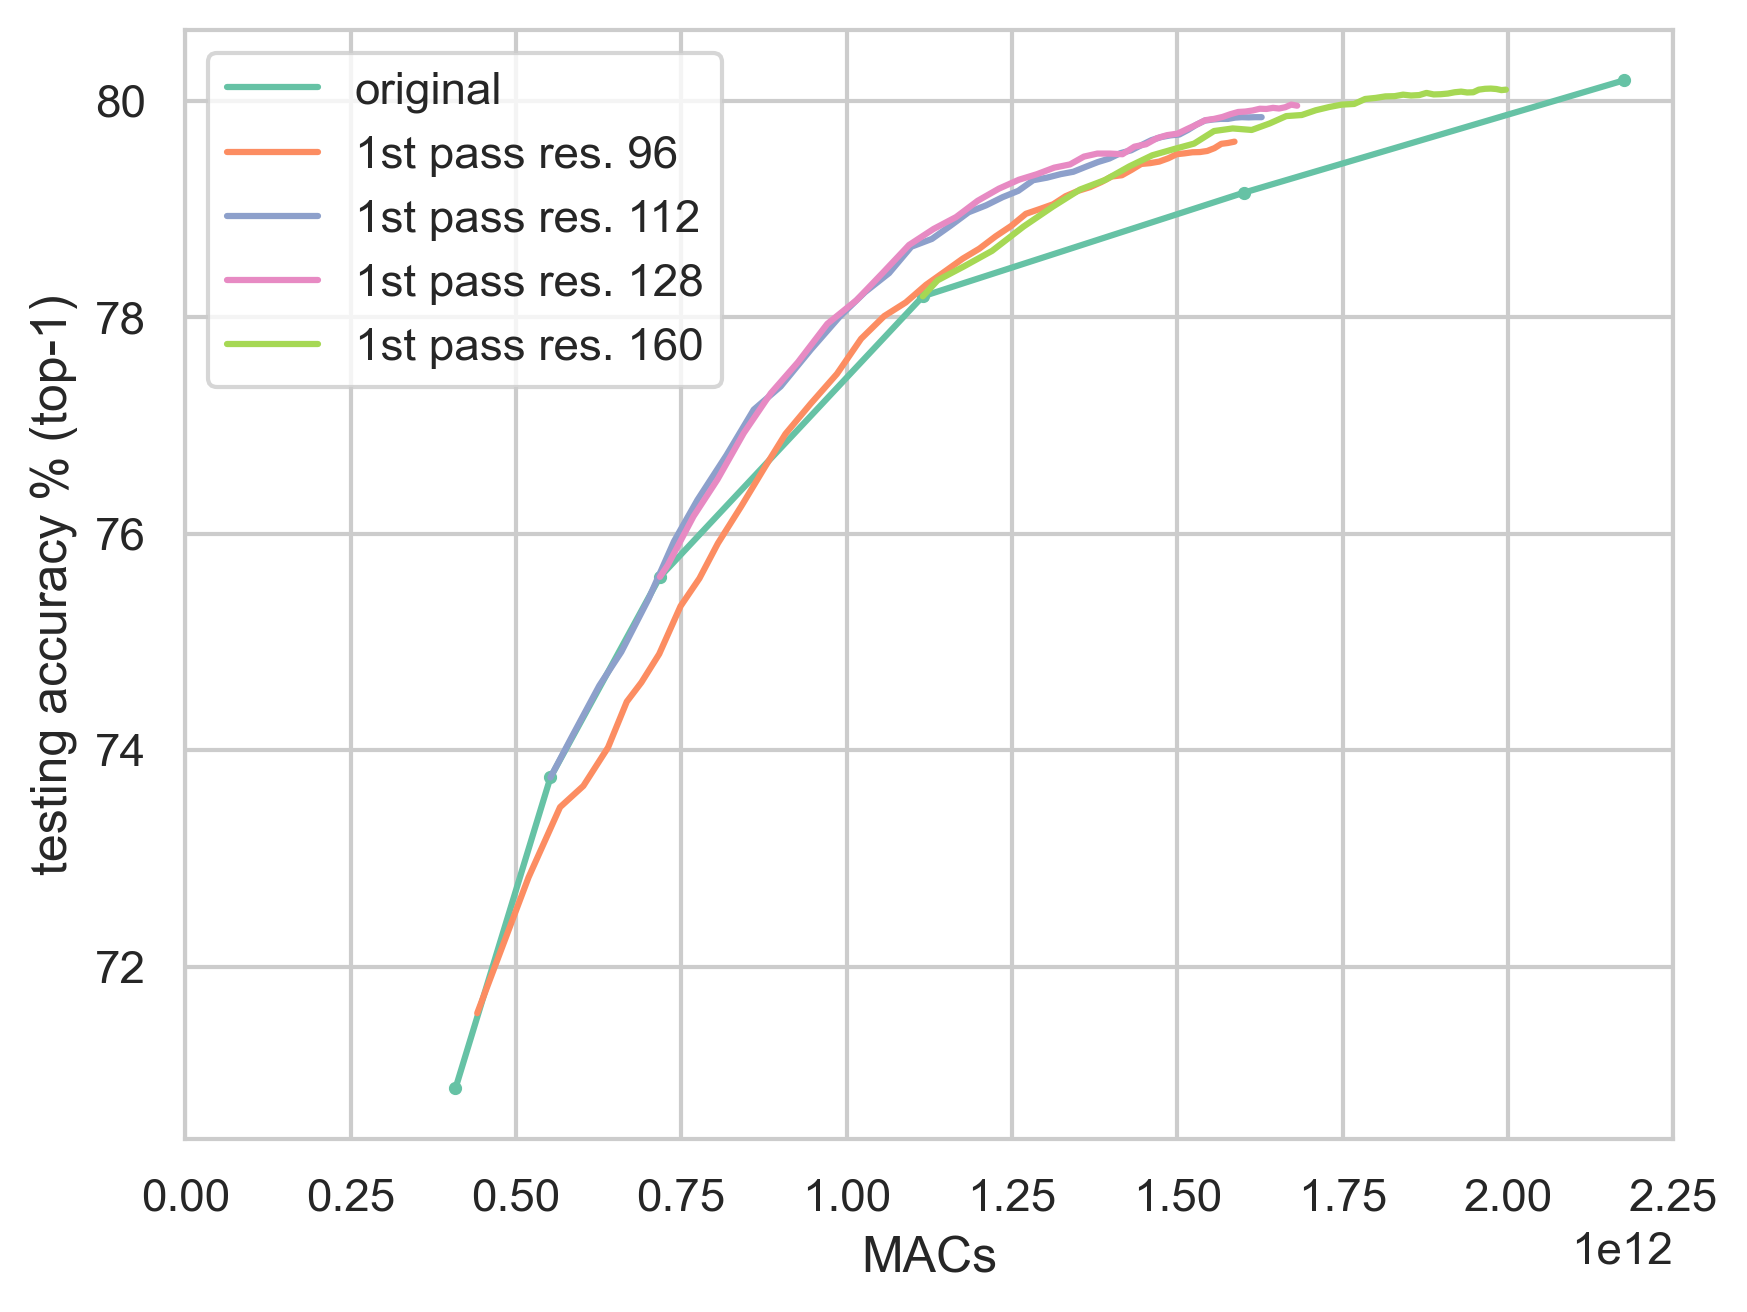

In [12]:
acc_cost_all = pd.concat([acc_cost_ori] + acc_cost)

fig, ax = plt.subplots()
sns.lineplot(hue="label", data=acc_cost_all, x=1, y=0, ax=ax, palette="Set2")
sns.scatterplot(acc_cost_ori, x=1, y=0, s=12, ax=ax, color=sns.color_palette("Set2")[0])
plt.xlabel("MACs")
plt.ylabel("testing accuracy % (top-1)")
plt.xlim(0, 2.25e12)
plt.savefig("test_acc1.svg")